In [17]:
import pandas as pd
import numpy as np
import statistics
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import timeit

2020-10-19 17:40:46.306441 - user 9201 - retry 0 - time 0.07220077514648438 
        - returncode 0 
        - command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x555e443cfe90.3058472/bl_129ykn']

In [2]:
with open('../data/slurm_wrapper_ce5.log') as f:
    data = ([line.split() for line in f if 'sbatch' in line and 'user 9204' in line])
with open('../data/slurm_wrapper_ce6.log') as f:
    data.extend([line.split() for line in f if 'sbatch' in line and 'user 9204' in line])

In [3]:
sbatch = pd.DataFrame([[pd.to_datetime(x[0] + 'T' + x[1]), float(x[10]), int(x[13])] 
                       for x in data], columns=['BEGIN', 'DURATION', 'RETURNCODE'])

In [4]:
sbatch['RETURNCODE'].value_counts()

0    57951
1     3296
Name: RETURNCODE, dtype: int64

In [5]:
# Check the duration of the process which ran before the one that timed out to see if we can
#  use this to flag the load if it is getting to be too much 
before = []
for index, row in sbatch.iterrows():
    if index and row['RETURNCODE'] == 1:
        before.append(sbatch.iloc[index - 1]['DURATION'])
print(statistics.mean(before))
print(statistics.stdev(before))
print(statistics.median(before))

9.843361352470893
9.731232890541792
7.185113787651062


{'whiskers': [<matplotlib.lines.Line2D at 0x1bd443cff70>,
 'caps': [<matplotlib.lines.Line2D at 0x1bd443e9670>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bd443cfc10>],
 'medians': [<matplotlib.lines.Line2D at 0x1bd443e9d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bd443f60d0>],
 'means': []}

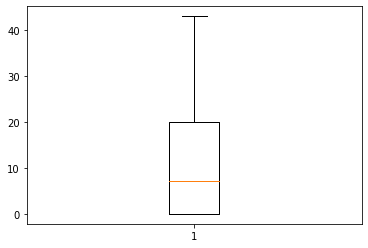

In [6]:
plt.boxplot(before)

In [7]:
count = 0
for index, row in sbatch.iterrows():
    if index and row['RETURNCODE'] == 1 and sbatch.iloc[index - 1]['RETURNCODE'] == 0:
        count += 1
print(count)

2098


In [8]:
sbatch.describe()

,DURATION,RETURNCODE
count,61247.000000,61247.000000
mean,2.066355,0.053815
std,5.271746,0.225654
min,0.018579,0.000000
25%,0.045495,0.000000
50%,0.076634,0.000000
75%,0.306675,0.000000
max,56.397141,1.000000


In [9]:
dur = [math.modf(x) for x in sbatch['DURATION']]

In [10]:
# next(zip(*test[:10]))

In [11]:
td_input = [[x[1], x[0] * 1000000] for x in dur]
dur_td = [timedelta(seconds=x[0], microseconds=x[1]) for x in td_input]

In [12]:
sbatch['END'] = sbatch['BEGIN'].add(dur_td)

In [47]:

begin_load_df = sbatch[['BEGIN','RETURNCODE']].rename(columns={'BEGIN':'TIME'})
begin_load_df['process'] = 1
end_load_df = sbatch[['END','RETURNCODE']].rename(columns={'END':'TIME'})
end_load_df['process'] = -1
load_df = begin_load_df.append(end_load_df)
load_df = load_df.sort_values('TIME').reset_index()

In [48]:
load_df['running'] = np.cumsum(load_df['process'])

In [49]:
load_df['running'].value_counts()

1    61043
0    59136
2     2076
3      201
4       35
5        3
Name: running, dtype: int64

In [50]:
load_df[load_df['RETURNCODE'] == 1]

,index,TIME,RETURNCODE,process,running
894,30637,2020-10-18 06:16:25.392946,1,1,1
896,30637,2020-10-18 06:16:45.430618,1,-1,1
904,30640,2020-10-18 06:38:44.172473,1,1,1
907,30640,2020-10-18 06:39:04.211209,1,-1,0
912,220,2020-10-18 06:53:44.272915,1,1,1
...,...,...,...,...,...
120385,29882,2021-10-02 08:14:35.640726,1,-1,0
120546,29922,2021-10-02 18:29:08.267199,1,1,1
120547,29922,2021-10-02 18:29:28.310345,1,-1,0
122004,61124,2021-10-06 15:39:20.269943,1,1,1


In [53]:
for i in range(0, len(load_df)):
    if load_df.iloc[i]['RETURNCODE'] == 1:
        print(i)
        print(load_df.iloc[i-10:i+10])
        break

894
     index                       TIME  RETURNCODE  process  running
884  30634 2020-10-18 05:38:50.354467           0        1        1
885  30634 2020-10-18 05:39:02.328469           0       -1        0
886    215 2020-10-18 05:53:12.066123           0        1        1
887    215 2020-10-18 05:53:12.118405           0       -1        0
888  30635 2020-10-18 06:01:16.047091           0        1        1
889    216 2020-10-18 06:01:16.084626           0        1        2
890  30635 2020-10-18 06:01:20.859826           0       -1        1
891    216 2020-10-18 06:01:30.847517           0       -1        0
892  30636 2020-10-18 06:08:34.050705           0        1        1
893  30636 2020-10-18 06:08:34.155586           0       -1        0
894  30637 2020-10-18 06:16:25.392946           1        1        1
895  30638 2020-10-18 06:16:36.503204           0        1        2
896  30637 2020-10-18 06:16:45.430618           1       -1        1
897  30638 2020-10-18 06:16:47.613070       

In [54]:
sbatch[(sbatch['BEGIN'].dt.month == 10) & (sbatch['BEGIN'].dt.day == 18)]['RETURNCODE'].sum()

18